# Part1 - Preprocessing

## Import libaries

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import talib as ta

## Import training set

In [50]:
rsiPeriod = 14
numberOfFeatures = 2
trainingDataPoints = 3500

In [51]:
dataTrain = pd.read_csv("goog.csv") #import csv
dataTrain['CloseEdited'] = dataTrain['Close'].astype(float)
dataTrain["RSI"] = ta.RSI(dataTrain['CloseEdited'],rsiPeriod)
newTrain = pd.DataFrame()
newTrain["Open"] = dataTrain['Open']
newTrain['RSI'] = dataTrain['RSI'].fillna(0)
trainingSet = newTrain.iloc[:,0:numberOfFeatures].values #convert to numpy to train RNN
trainingSet
ySet = newTrain.iloc[:,0:1].values

## Feature Scaling

In [52]:
# Use normalization x - min(x) / max(min) - min(x)
sc = MinMaxScaler(feature_range=(0,1)) # all values between 0 and 1
ySC = MinMaxScaler(feature_range=(0,1))
ySCSet = ySC.fit_transform(ySet)
scaleTrainingSet = sc.fit_transform(trainingSet)
scaleTrainingSet

array([[1.35827890e-04, 0.00000000e+00],
       [3.05192214e-04, 0.00000000e+00],
       [1.93847539e-03, 0.00000000e+00],
       ...,
       [9.09108971e-01, 4.67463591e-01],
       [9.03049569e-01, 3.96762627e-01],
       [9.05328584e-01, 3.85300827e-01]])

## Create a data structure woth 60 timesteps and 1 output

In [53]:
# Look at the 60 previous timesteps to predict this timestep
xTrain = []
yTrain = []
for i in range(60,trainingDataPoints):
    xTrain.append(scaleTrainingSet[i-60:i])
    yTrain.append(scaleTrainingSet[i])

In [54]:
# convert xtrain and yTrain to numpy for RNN
xTrain, yTrain = np.array(xTrain), np.array(yTrain)

## Reshaping the data

In [55]:
xTrain = np.reshape(xTrain, (xTrain.shape[0],xTrain.shape[1],numberOfFeatures)) #batchsize, inputSize, numberOfFeatures

# Part 2 - Build RNN

## Initalizing the RNN

In [56]:
regressor = Sequential()

## Adding LSTM layers and some dropout regularization

In [57]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (xTrain.shape[1],numberOfFeatures))) 
regressor.add(Dropout(rate = 0.2))

In [58]:
regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(rate = 0.2))

In [59]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [60]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(rate = 0.2))
# Last Layer

## Adding output layer

In [61]:
regressor.add(Dense(units=1))

In [62]:
regressor.compile(optimizer='adam',loss='mean_squared_error',metrics='accuracy')

In [63]:
regressor.fit(xTrain,yTrain,epochs=100,batch_size=32)

Epoch 1/100
108/108 [==============================] - 12s 59ms/step - loss: 0.0710 - accuracy: 0.0000e+00
Epoch 2/100
108/108 [==============================] - 6s 60ms/step - loss: 0.0668 - accuracy: 0.0000e+00
Epoch 3/100
108/108 [==============================] - 6s 60ms/step - loss: 0.0660 - accuracy: 0.0000e+00
Epoch 4/100
108/108 [==============================] - 7s 62ms/step - loss: 0.0657 - accuracy: 0.0000e+00
Epoch 5/100
108/108 [==============================] - 7s 64ms/step - loss: 0.0655 - accuracy: 0.0000e+00
Epoch 6/100
108/108 [==============================] - 7s 66ms/step - loss: 0.0650 - accuracy: 0.0000e+00
Epoch 7/100
108/108 [==============================] - 8s 70ms/step - loss: 0.0647 - accuracy: 0.0000e+00
Epoch 8/100
108/108 [==============================] - 7s 61ms/step - loss: 0.0644 - accuracy: 0.0000e+00
Epoch 9/100
108/108 [==============================] - 7s 61ms/step - loss: 0.0641 - accuracy: 0.0000e+00
Epoch 10/100
108/108 [=======================

## Part 3 - Predictions and visualing the results

In [64]:
dataTest = pd.read_csv("goog.csv") #import csv
dataTest = dataTest[trainingDataPoints + 1:]
dataTest["RSI"] = ta.RSI(dataTest['Open'],rsiPeriod).fillna(0)
newTest = pd.DataFrame()
newTest["Open"] = dataTest['Open']
newTest['RSI'] = dataTest['RSI']
realStockPrice = dataTest.iloc[:,1:2].values #convert to numpy to train RNN
newTest

,Open,RSI
3501,1172.219971,0.000000
3502,1196.560059,0.000000
3503,1191.000000,0.000000
3504,1186.959961,0.000000
3505,1181.010010,0.000000
...,...,...
4381,2831.090088,46.681265
4382,2836.810059,47.247461
4383,2750.000000,40.259966
4384,2732.000000,38.972923


## Predict price in 2017

In [65]:
datasetTotal = pd.concat((newTrain,newTest),axis=0)
inputs = datasetTotal[len(datasetTotal) - len(newTest) - 60:].values
inputs = sc.transform(inputs)

In [66]:
xTest = []
for i in range(60,len(inputs)):
    xTest.append(inputs[i-60:i])
xTest = np.array(xTest)
xTest = np.reshape(xTest, (xTest.shape[0],xTest.shape[1],numberOfFeatures)) #batchsize, inputSize, numberOfFeatures

In [67]:
predictedPrice = regressor.predict(xTest)
predictedPrice = ySC.inverse_transform(predictedPrice)


# Visualsing the data

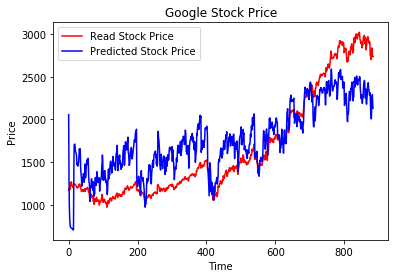

In [68]:
plt.plot(realStockPrice, color = 'red', label = "Read Stock Price")
plt.plot(predictedPrice, color = 'blue', label = "Predicted Stock Price")
plt.title("Google Stock Price")
plt.xlabel('Time')
plt.ylabel("Price")
plt.legend()
plt.show()

In [77]:
stocksOwned = {}
startingValue = 500_000
liquidValue = startingValue

for i in range(len(predictedPrice)):
    if realStockPrice[i] < predictedPrice[i] and 'GOOGL' not in stocksOwned:
        stocksOwned['GOOGL'] = (realStockPrice[i], liquidValue/realStockPrice[i])
        liquidValue -= liquidValue/realStockPrice[i] * realStockPrice[i]
    elif 'GOOGL' in stocksOwned and stocksOwned['GOOGL'][0] < realStockPrice[i]:
        liquidValue += stocksOwned['GOOGL'][1] * realStockPrice[i]
        stocksOwned.pop('GOOGL')

profit = (liquidValue - startingValue)[0]
profitPercentage = (profit/startingValue)*100
print("Profit: ${}".format(profit))


Profit: $413189.9709822193
